# Сессионное задание: Диффузионные модели

**План задания** (суммарно **50 баллов**)

1. **2D-датасет SwissRoll** (суммарно **40 баллов**)
    1. Реализовать прямой и обратный процессы диффузии и обучить базовый DDPM. (20 баллов)
    2. Реализовать classifier-free guidance. (10 баллов)
    3. Реализовать ускоренный семплинг. (10 баллов)

2. **Датасет MNIST** (суммарно **10 баллов**)
    1. Визуализировать прямой диффузионный процесс. (1 балл)
    2. Обучить диффузионную модель с визуально хорошим качеством генерации. (7 баллов)
    3. Сравнить генерации с помощью classifier-free guidance для разных значений guidance scale. (2 балла)

Ваша задача — заполнить пропуски внутри блоков с подписью `ваш код`.


Если вы работаете в `Google Colab`, нужно, чтобы Python «видел» дополнительный файл `utils.py`, который приложен к заданию:

1. Загрузите файл `utils.py` на ваш Google Drive.
2. Раскомментируйте код ниже.
3. Укажите в переменной `path` путь к файлу `utils.py` на вашем Google Drive.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = "drive/MyDrive/Teaching/2025-generative-model-miphi/Домашки/3_diffusion/utils.py"
# !cp $path .

In [18]:
import os
import re
import random

import numpy as np
import seaborn as sns
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

from utils import get_labeled_data_loader, MyUNet

In [20]:
print("Версия PyTorch:", th.__version__)

Версия PyTorch: 2.5.1+rocm6.2


## DDPM

В этой части мы реализуем свою собственную модель (DDPM) и применим её на датасете SwissRoll.

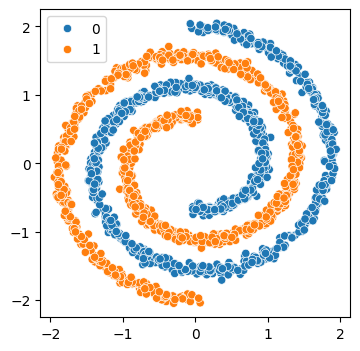

In [7]:
def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(2000)
y = y.astype(int)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

**Кратко повторим теорию диффузионных моделей.**

Диффузионная модель состоит из прямого и обратного процессов.

Прямой процесс задаётся условным распределением $q(x_{1:T} \mid x_0)$.

Это марковская цепь, которая последовательно добавляет гауссовский шум к исходному объекту $x_0$.

На каждом шаге добавляется шум некоторой величины, которая определяется расписанием дисперсий $\{\beta_1, \ldots, \beta_T\}$.

Если это расписание выбрано правильно и $T$ стремится к бесконечности (или достаточно велико), процесс сходится к стандартному гауссовскому распределению $\mathcal{N}(0, I)$.

Распределения $q$ имеют следующий вид:
$$
 q(x_t \mid x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}\,x_{t - 1}, \beta_t I),
 \qquad
 q(x_{1:T}\mid x_0) = \prod_{t = 1}^T q(x_t \mid x_{t - 1}).
$$

Теперь рассмотрим обратный процесс.

Обратный процесс последовательно удаляет шум, начиная с чистого гауссовского шума, до тех пор, пока не будет получен объект из исходного распределения.

Таким образом, диффузионная модель является вероятностной моделью с латентными переменными
$p_\theta(x_0) := \int p_\theta(x_{0:T}) \, dx_{1:T}$,
где латентные переменные $x_1, \ldots, x_T$ соответствуют зашумлённым объектам, а $x_0$ — объекту из исходного распределения.

Совместное распределение $p_\theta(x_{0:T})$ определяет обратный процесс диффузии и по сути представляет собой марковскую цепь гауссовых распределений $p_\theta(x_{t-1}\mid x_t)$:

$$
p_\theta(x_{0:T}) = p_\theta(x_T)\,\prod_{t = 1}^T p_\theta(x_{t-1}\mid x_t),
\qquad
p_\theta(x_T) = \mathcal{N}(x_T \mid 0, I),
$$
$$
p_{\theta}(x_{t - 1}\mid x_t) := \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t)).
$$

Вернёмся к распределению $q(x_t \mid x_{t - 1})$.

Чтобы получить $x_t$, нам нужно итеративно вычислить $x_1, \ldots, x_{t - 1}$.

Однако благодаря свойствам гауссовского распределения это можно сделать более эффективно.

Обозначим
$\alpha_t := 1 - \beta_t$ и $\bar{\alpha}_t := \prod_{i = 1}^t \alpha_i$.

Тогда
$$
q(x_t \mid x_0) = \mathcal{N}\bigl(x_t;\sqrt{\bar{\alpha}_t}\,x_0, (1-\bar{\alpha}_t)I\bigr). \qquad (1)
$$

В результате модель может быть обучена путём оптимизации отдельных членов суммы вариационной нижней границы:
$$
L_{VLB} = \mathbb{E}_q \Big[
\underbrace{D_\text{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T}
+ \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))}_{L_{t-1}}
\underbrace{- \log p_\theta(\mathbf{x}_0 \mid \mathbf{x}_1)}_{L_0}
\Big].
$$

Для обучения необходимо выписать следующее распределение
$q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I})$:

$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) =
\frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}\,\mathbf{x}_t
+ \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}\,\mathbf{x}_0
\qquad (2)
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t. \qquad (3)
$$

Подробности можно найти в работе [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239).

В этой статье было показано, что при обучении с более простой функцией потерь достигаются лучшие результаты.

Вспомним, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I). \qquad (4)
$$

Пусть наша модель предсказывает $\epsilon$ из приведённого выше выражения, обучаясь путём оптимизации следующей функции потерь:
$$
L^{\text{simple}}_t = \mathbb{E}_{x_0, \epsilon, t}\big[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2 \big].
$$

В этом задании будет использоваться именно эта функция потерь.

Для выполнения семплинга (обратного процесса) нам необходимо получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$.

Для этого найдите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в уравнение (2).

_____

In [8]:
# Это вспомогательная функция, которая понадобится вам в этом задании.
# Например, когда вы захотите по батчу временных меток брать из предвычисленного массива
# соответствующие коэффициенты прямого диффузионного процесса.

def _extract_into_tensor(arr: th.Tensor, timesteps: th.Tensor, broadcast_shape: Tuple):
    """
    Вытаскивает значения из одномерного тензора по батчу индексов.

    Параметры:
    - arr: одномерный тензор.
    - timesteps: батч индексов, по которым хотим извлечь значения из тензора.
    - broadcast_shape: shape с K размерностями, к которому нужно привести итоговый тензор.

    Возвращает: тензор с shape [batch_size, 1, ...], где shape имеет K размерностей.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [9]:
# Функция, которая возвращает список «рабочих» коэффициентов betas для диффузионного процесса
# в зависимости от длины марковской цепочки.

def get_beta_schedule(num_diffusion_timesteps: int) -> th.Tensor:
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    betas = th.from_numpy(betas).double()
    return betas

In [10]:
# Класс BaseDiffusion принимает на вход коэффициенты betas, которые задают и прямой, и обратный процессы.
# Также в этом классе мы предварительно вычисляем величины, которые пригодятся нам позднее.

class BaseDiffusion:
    def __init__(self, betas: th.Tensor) -> None:
        self.betas = betas
        self.alphas = 1 - self.betas
        self.alphas_cumprod = th.cumprod(self.alphas, dim=-1)
        self.num_timesteps = len(self.betas)

basediff = BaseDiffusion(get_beta_schedule(20))
basediff.alphas_cumprod

tensor([9.9500e-01, 9.3792e-01, 8.3499e-01, 6.9964e-01, 5.4958e-01, 4.0293e-01,
        2.7431e-01, 1.7238e-01, 9.9302e-02, 5.2003e-02, 2.4510e-02, 1.0268e-02,
        3.7641e-03, 1.1827e-03, 3.0969e-04, 6.4872e-05, 1.0192e-05, 1.0674e-06,
        5.5900e-08, 0.0000e+00], dtype=torch.float64)

### Реализуйте прямой процесс диффузии

In [11]:
class ForwardDiffusion(BaseDiffusion):
    def q_mean_variance(self, x0: th.Tensor, t: th.Tensor) -> th.Tensor:
        # ====
        # ваш код
        # посчитайте среднее и дисперсию q(x_t | x_0) (используйте выражение (1))
        # q(x_t | x_0) = N(x_t; sqrt(alphas_cumprod) * x_0, (1-alphas_cumprod) * I)
        # где alphas_cumprod - это кумулятивное произведение альф на шагах от 0 до t
        mean = _extract_into_tensor(th.sqrt(self.alphas_cumprod), t, x0.shape) * x0
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x0.shape)
        # ====
        return mean, variance

    def q_sample(self, x0: th.Tensor, t: th.Tensor, noise: Optional[th.Tensor]=None) -> th.Tensor:
        if noise is None:
            noise = th.randn_like(x0)
        # ====
        # ваш код
        # просемплируйте из q(x_t | x_0) (используйте выражение (1))
        sqrt_alphas_cumprod_t = _extract_into_tensor(th.sqrt(self.alphas_cumprod), t, x0.shape)
        sqrt_one_minus_alphas_cumprod_t = _extract_into_tensor(th.sqrt(1.0 - self.alphas_cumprod), t, x0.shape)
        samples = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
        # ====
        return samples

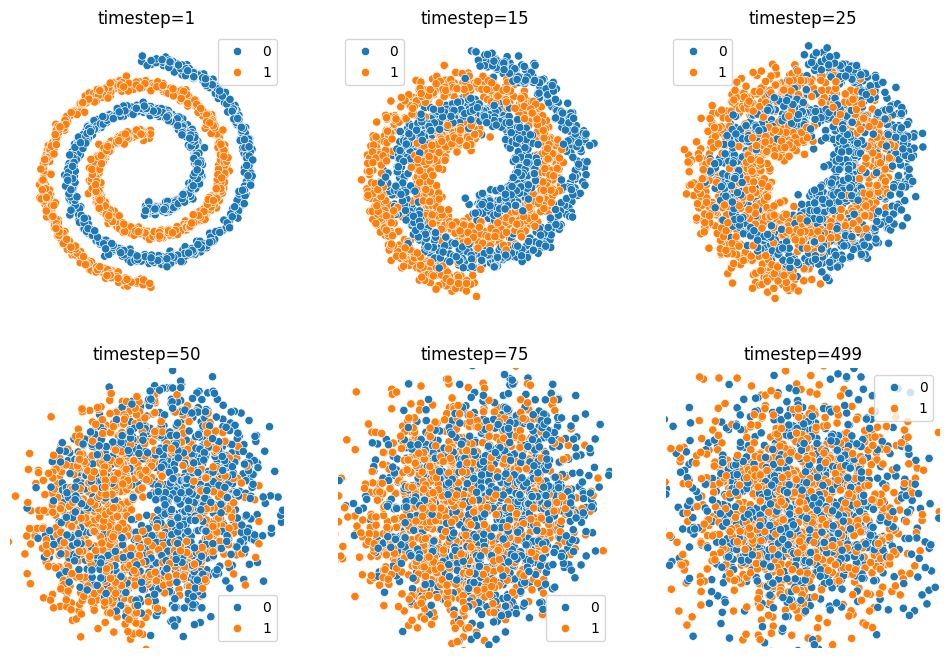

In [12]:
# Посмотрим на прямой процесс диффузии, применённый к SwissRoll

T = 500
forward_diffusion = ForwardDiffusion(get_beta_schedule(T))

timesteps_to_plot = [1, 15, 25, 50, 75, 499]
n_plots = len(timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        X_noised = forward_diffusion.q_sample(
            x0=th.from_numpy(X),
            t=th.ones_like(th.from_numpy(y)).long() * timesteps_to_plot[idx],
        )
        sns.scatterplot(x=X_noised[:, 0], y=X_noised[:, 1], hue=y, ax=axes[i, j])
        axes[i, j].set_title(f"timestep={timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

### Реализуйте обратный процесс диффузии

In [13]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = th.cat(
            [th.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )
        # ====
        # ваш код
        # посчитайте дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте выражение (3))
        self.variance = (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod) * self.betas
        # ====

        # ====
        # ваш код
        # посчитайте коэффициенты среднего значения q(x_{t-1} | x_t, x_0) (используйте выражение (2))
        self.xt_coef = (th.sqrt(self.alphas) * (1.0 - self.alphas_cumprod_prev)) / (1.0 - self.alphas_cumprod)
        self.x0_coef = (th.sqrt(self.alphas_cumprod_prev) * self.betas) / (1.0 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        # ====
        # ваш код
        # посчитайте x0 (используйте выражения (4) и (2))
        sqrt_alphas_cumprod_t = _extract_into_tensor(th.sqrt(self.alphas_cumprod), t, xt.shape)
        sqrt_one_minus_alphas_cumprod_t = _extract_into_tensor(th.sqrt(1.0 - self.alphas_cumprod), t, xt.shape)
        x0 = (xt - sqrt_one_minus_alphas_cumprod_t * eps) / sqrt_alphas_cumprod_t
        # ====
        return x0

    def q_posterior_mean_variance(
        self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor
    ) -> Tuple[th.Tensor, th.Tensor]:
        # ====
        # ваш код
        # посчитайте среднее и дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте выражения (2) и (3))
        # Сначала восстанавливаем x_0 из xt и eps
        x0 = self.get_x0(xt, eps, t)

        # Затем вычисляем коэффициенты для среднего
        xt_coef = _extract_into_tensor(self.xt_coef, t, xt.shape)
        x0_coef = _extract_into_tensor(self.x0_coef, t, xt.shape)
        mean = xt_coef * xt + x0_coef * x0

        # И дисперсию
        variance = _extract_into_tensor(self.variance, t, xt.shape)
        # ====
        return mean, variance

    def p_sample(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        # прочитайте код для одного шага генерации внимательно
        mean, variance = self.q_posterior_mean_variance(xt=xt, eps=eps, t=t)
        noise = th.randn_like(xt, device=xt.device)

        nonzero_mask = th.ones_like(t) # чтобы не добавлять шум, если t = 0
        nonzero_mask[t == 0] = 0
        nonzero_mask = _extract_into_tensor(
            nonzero_mask, th.arange(nonzero_mask.shape[0]), xt.shape
        )
        nonzero_mask = nonzero_mask.to(xt.device)

        sample = mean + nonzero_mask * variance.sqrt() * noise
        return sample.float()

### Реализуем архитектуру нейронной сети для предсказания шума

In [14]:
# Заметьте, что модель на вход принимает не только зашумлённый объект,
# но также момент времени и индекс класса.

class ConditionalMLP(nn.Module):
    def __init__(self, d_in: int, T: int, n_classes: int, hidden_dim: Optional[int]=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(d_in, self.hidden_dim)
        self.t_proj = nn.Embedding(T, self.hidden_dim)
        self.y_embed = nn.Embedding(n_classes, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, 2 * self.hidden_dim),
            nn.GELU(),
            nn.Linear(2 * self.hidden_dim, d_in)
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t, y):
        """
        Параметры:
        - x: зашумлённая картинка.
        - t: счётчик времени/уровень шума.
        - y: индекс класса, который нужно сгенерировать.
        """
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        y = self.y_embed(y)
        x = x + t + y
        x = F.gelu(x)
        return self.backbone(x)

### Реализуйте DDPM

In [15]:
class DDPM(nn.Module):
    def __init__(
        self,
        betas: th.Tensor,
        model: nn.Module,
        shape: Optional[th.Tensor] = None,
    ) -> None:
        super().__init__()

        self.forward_diffusion = ForwardDiffusion(betas=betas)
        self.reverse_diffusion = ReverseDiffusion(betas=betas)
        self.model = model
        self.num_timesteps = len(betas)

        self.register_buffer("betas", betas)
        self.register_buffer("shape", shape)

    @property
    def device(self) -> None:
        return next(self.parameters()).device

    @th.no_grad()
    def sample(self, y: th.Tensor) -> th.Tensor:
        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)
            # ====
            # ваш код
            # 1) предскажите шум с помощью модели
            # 2) сделайте шаг разшумления

            # Предсказание шума
            eps = self.model(x, t, y)
            # Выполнение шага разшумления
            x = self.reverse_diffusion.p_sample(x, eps, t)
            # ====
        return x, y

    def train_loss(self, x0: th.Tensor, y: th.Tensor) -> th.Tensor:
        if self.shape is None:
            self.shape = th.tensor(list(x0.shape)[1:], device="cpu")
        t = th.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = th.randn_like(x0)
        # ====
        # ваш код
        # 1) зашумите x0 и получите xt
        # 2) предскажите по xt наложенный на него шум
        
        # Зашумляем x0 с помощью forward_diffusion
        xt = self.forward_diffusion.q_sample(x0, t, noise=noise)
        # Предсказываем шум с помощью модели
        eps = self.model(xt, t, y)
        # ====
        loss = F.mse_loss(eps, noise)
        return loss

In [16]:
# Теперь давайте обучим наш DDPM.

def train_model(
    ddpm: DDPM,
    dataloader: DataLoader,
    *,
    lr: float,
    n_iters: int,
    device: str = "cpu",
    log_every: int = 500
):
    ddpm.to(device)

    optimizer = th.optim.Adam(ddpm.model.parameters(), lr=lr)

    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < n_iters:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)

        x, y = batch["x"].to(device), batch["y"].to(device)

        loss = ddpm.train_loss(x, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{n_iters} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

In [22]:
# Проверяем доступность GPU (ROCm)
device = 'cuda' if th.cuda.is_available() else 'cpu'
if device == 'cpu':
    print("Внимание: ROCm/GPU не обнаружен. Вычисления будут на CPU.")

if device == 'cuda':
    print("Вычисления будут на GPU:", th.cuda.get_device_name(0))

    

Вычисления будут на GPU: AMD Radeon RX 7800 XT


In [23]:
T = 500
BATCH_SIZE = 1024
LR = 0.01
N_ITERS = 10000

model = ConditionalMLP(d_in=2, T=T, n_classes=2)
# device = "cpu" # можно считать на гпу, но цпу должно быть достаточно
device = 'cuda'


ddpm = DDPM(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

/home/gna/anaconda3/envs/rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Step 500/10000 Loss: 0.2854
Step 1000/10000 Loss: 0.2616
Step 1500/10000 Loss: 0.2612
Step 2000/10000 Loss: 0.2542
Step 2500/10000 Loss: 0.2487
Step 3000/10000 Loss: 0.2457
Step 3500/10000 Loss: 0.2441
Step 4000/10000 Loss: 0.2424
Step 4500/10000 Loss: 0.2412
Step 5000/10000 Loss: 0.2392
Step 5500/10000 Loss: 0.2385
Step 6000/10000 Loss: 0.239
Step 6500/10000 Loss: 0.2377
Step 7000/10000 Loss: 0.2379
Step 7500/10000 Loss: 0.2372
Step 8000/10000 Loss: 0.2374
Step 8500/10000 Loss: 0.2363
Step 9000/10000 Loss: 0.2354
Step 9500/10000 Loss: 0.2367
Step 10000/10000 Loss: 0.2347


100%|██████████| 500/500 [00:00<00:00, 1540.82it/s]


Text(0.5, 1.0, 'real')

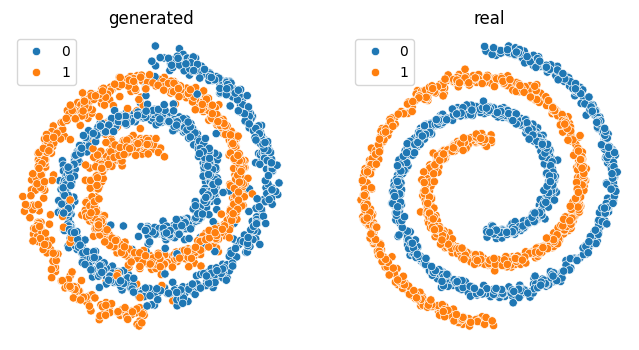

In [24]:
# Теперь давайте посмотрим, что наша модель научилась генерировать (должно быть похоже на наш SwissRoll датасет)

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(ys)

_, (ax_gen, ax_real) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=ax_gen); ax_gen.set_axis_off();
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax_real); ax_real.set_axis_off();

ax_gen.set_title("generated")
ax_real.set_title("real")

## Classifier-free guidance

К этому моменту мы реализовали базовый алгоритм для диффузионных моделей DDPM.

Теперь реализуем **classifier-free guidance** — технику для улучшения class-conditional генерации, которую мы разбирали на лекции.

Итоговая формула очень простая:
$$
\hat{\epsilon}_\theta(x_t, t, y) =
\epsilon_\theta(x_t, t, y=\varnothing)
+ s\bigl(\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, y=\varnothing)\bigr), \qquad (1)
$$
где:
- $\epsilon_\theta(x_t, t, y)$ — модель, которую мы обучаем;
- $s$ — guidance scale (контролирует силу guidance);
- $\hat{\epsilon}_\theta(x_t, t, y)$ — итоговая модель для предсказания шума;
- $y$ — класс, который мы хотим сгенерировать;
- $y = \varnothing$ означает, что в нейронную сеть подаётся специальный «пустой» класс для unconditional-режима.

**Обучение** происходит следующим образом:

1. Семплируем
   $$
   (x_0, c) \sim p_{\text{data}}, \quad
   t \sim \text{Uniform}\{1, \ldots, T\}, \quad
   \epsilon \sim \mathcal{N}(0, I).
   $$
2. Зашумляем данные:
   $$
   x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1 - \bar{\alpha}_t}\,\epsilon.
   $$
3. С вероятностью $p$ выбираем, учим ли мы модель в unconditional- или conditional-режиме:
   - unconditional:
     $$
     \|\epsilon_\theta(x_t, t, y=\varnothing) - \epsilon\|_2^2,
     $$
   - conditional:
     $$
     \|\epsilon_\theta(x_t, t, y=c) - \epsilon\|_2^2.
     $$

*Замечание.* Логика выбора unconditional-/conditional-режима обучения реализована за вас в классе `LabeledDataset` (лежит в `utils.py`). Это сделано затем, чтобы можно было переиспользовать функцию `train_model` без изменений. Обратите внимание на параметр `drop_label`.


### Реализуйте Classifier-free Guidance

In [25]:
class DDPMWithCFG(DDPM):
    @th.no_grad()
    def sample_with_cfg(self, y: th.Tensor, guidance_scale: float=0., null_label: int=2):
        """
        Параметры:
        - y: метка класса;
        - guidance_scale:
            - 0: unconditional-режим;
            - 1: conditional-режим, честно восстанавливающий распределение;
            - чем выше значение, тем сильнее влияние класса;
        - null_label: заранее подготовленный индекс класса, отвечающий за unconditional-обучение.
        """
        assert self.shape is not None
        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)
            # ====
            # ваш код
            # 1) предскажите epsilon с крышечкой с помощью метод `_predict_eps_hat`
            # 2) сделайте шаг разшумления
            eps_hat = self._predict_eps_hat(x, t, y, guidance_scale, null_label)
            x = self.reverse_diffusion.p_sample(x, eps_hat, t)
            # ====
        return x, y

    def _predict_eps_hat(self, x: th.Tensor, t: th.Tensor, y: th.Tensor, guidance_scale: float, null_label: int):
        null_y = null_label * th.ones_like(y)
        # ====
        # ваш код
        # предскажите epsilon с крышечкой с помощью модели (используйте выражение (1))
        eps_uncond = self.model(x, t, null_y)
        eps_cond = self.model(x, t, y)
        eps_hat = eps_uncond + guidance_scale * (eps_cond - eps_uncond)
        # ====
        return eps_hat

In [26]:
T = 500
BATCH_SIZE = 1024
LR = 0.01
N_ITERS = 30000
DROP_LABEL = 0.4

model = ConditionalMLP(d_in=2, T=T, n_classes=2+1)
# device = "cpu" # можно считать на гпу, но цпу должно быть достаточно
device = 'cuda'

ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True, drop_label=DROP_LABEL)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/30000 Loss: 0.2893
Step 1000/30000 Loss: 0.2664
Step 1500/30000 Loss: 0.2648
Step 2000/30000 Loss: 0.265
Step 2500/30000 Loss: 0.2617
Step 3000/30000 Loss: 0.2591
Step 3500/30000 Loss: 0.2575
Step 4000/30000 Loss: 0.2569
Step 4500/30000 Loss: 0.2567
Step 5000/30000 Loss: 0.2545
Step 5500/30000 Loss: 0.2531
Step 6000/30000 Loss: 0.2525
Step 6500/30000 Loss: 0.2516
Step 7000/30000 Loss: 0.2505
Step 7500/30000 Loss: 0.2505
Step 8000/30000 Loss: 0.2499
Step 8500/30000 Loss: 0.2493
Step 9000/30000 Loss: 0.2504
Step 9500/30000 Loss: 0.2492
Step 10000/30000 Loss: 0.2476
Step 10500/30000 Loss: 0.248
Step 11000/30000 Loss: 0.2479
Step 11500/30000 Loss: 0.2473
Step 12000/30000 Loss: 0.2476
Step 12500/30000 Loss: 0.2468
Step 13000/30000 Loss: 0.2466
Step 13500/30000 Loss: 0.2478
Step 14000/30000 Loss: 0.2477
Step 14500/30000 Loss: 0.2469
Step 15000/30000 Loss: 0.2475
Step 15500/30000 Loss: 0.2466
Step 16000/30000 Loss: 0.2467
Step 16500/30000 Loss: 0.2454
Step 17000/30000 Loss: 0.2467
St

100%|██████████| 500/500 [00:00<00:00, 1638.59it/s]


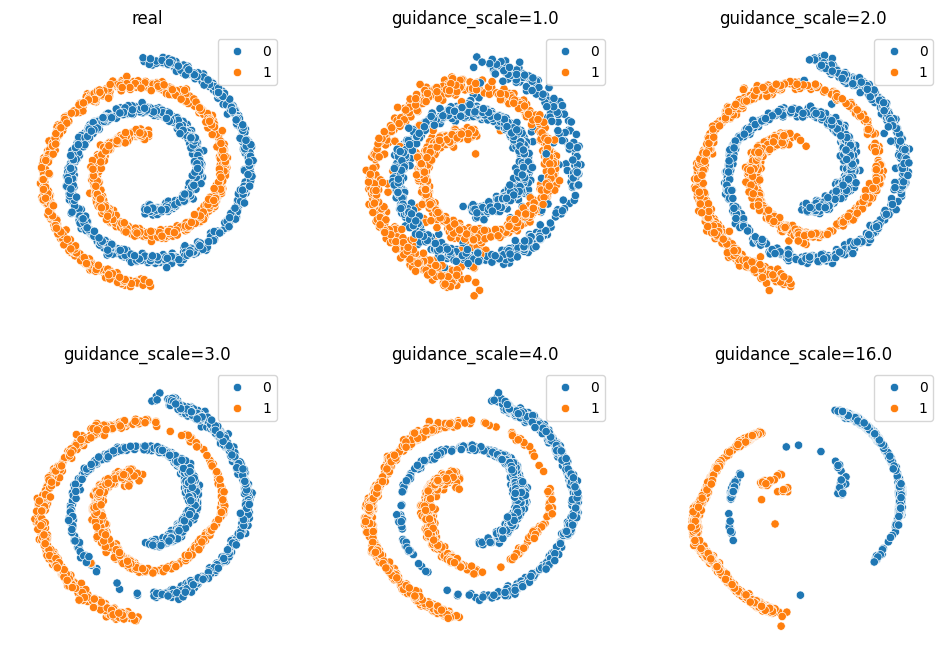

In [27]:
# Давайте посмотрим на качество генерации c разным guidance scale

guidance_scale_to_plot = [1.0, 2.0, 3.0, 4.0, 16.0]
n_plots = len(guidance_scale_to_plot) + 1
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        if idx == 0:
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[i, j])
            axes[i, j].set_title("real")
        else:
            idx = idx - 1
            Xs, ys = ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale_to_plot[idx], null_label=2)
            sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=axes[i, j])
            axes[i, j].set_title(f"guidance_scale={guidance_scale_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

**Замечания про classifier-free guidance:**
- генерирует семплы, которые более вероятны для конкретного класса (чем выше guidance scale, тем меньше пересечения между генерациями разных классов);
- слишком большой guidance scale может приводить к выбросам

## Ускоренный семплинг из DDPM

На данном этапе мы реализовали DDPM и технику classifier-free guidance.
В текущей реализации для генерации нужно делать столько же шагов, сколько вершин в марковской цепочке, а в случае использования classifier-free guidance — в два раза больше.
Это не критично для нашего игрушечного датасета SwissRoll, однако чем сложнее датасет и больше размерность данных, тем дороже становится каждый шаг генерации.

В этой части мы реализуем математически обоснованный способ пропускать некоторые вершины марковской цепочки для более быстрого семплинга из DDPM. Этот подход мы также обсуждали на лекции.

Вкратце вспомним, что там происходило.

Пусть у нас есть DDPM с максимальным индексом вершины в марковской цепочке $T$, и мы хотим семплировать за $I < T$ шагов.
При этом важно, чтобы мы могли переиспользовать предобученную на $T$ шагах диффузионную модель $\epsilon_\theta(x_t, t)$, где $t \in \{1, \ldots, T\}$.

Для этого мы искали более короткую марковскую цепочку длины $I$ (вершины будут проиндексированы $i \in \{1, \ldots, I\}$), которая является подцепочкой исходной более длинной:

1. Мы выбрали, каким вершинам исходной длинной цепочки будет соответствовать новая цепочка. Для этого мы задали функцию
   $\tau: \{1, \ldots, I\} \to \{1, \ldots, T\}$,
   которая отображает временные индексы новой цепочки в индексы старой. При этом важно, чтобы $\tau(I) = T$, чтобы новая цепочка всё так же заканчивалась в стандартном гауссовском распределении.

2. Далее мы формализовали наше желание, чтобы новая короткая цепочка была подцепочкой исходной. Для этого мы выровняли их соответствующие маргинальные распределения:
   $$
   q_{\text{new}}(x_i) = q(x_{t = \tau(i)}).
   $$

3. Это условие позволило нам найти параметры короткой диффузионной марковской цепочки:
   $$
   \beta_{\text{new}, i} = 1 - \alpha_{\text{new}, i}
   = 1 - \frac{\bar{\alpha}_{\tau(i)}}{\bar{\alpha}_{\tau(i - 1)}}. \qquad (1)
   $$

4. Также это позволило нам переиспользовать предобученную на длинной цепочке диффузионную модель $\epsilon_\theta(x_t, t)$:
   $$
   \epsilon_{\text{new}, \theta}(x_i, i) = \epsilon_\theta(x_t = x_i, t = \tau(i)). \qquad (2)
   $$

Таким образом, нам нужно сделать класс DDPM с правильными параметрами новой, более короткой марковской цепочки, определёнными выше, и корректным переиспользованием предобученной диффузионной модели, чтобы семплировать за $I < T$ шагов.


### Реализуйте WrappedModel и SpacedDDPMWithCFG

In [28]:
class WrappedModel(nn.Module):
    """
    Класс обёртка для предобученной диффузионной модели epsilon(x_t, t),
        которая позволяет учитывать отображение tau счётчиков времени из нового в старый.

    Параметры:
    - model: предобученная диффузионная модель epsilon(x_t, t)
    - timestep_map: массив, который по индексу i содержит время tau(i)
    """
    def __init__(self, model: nn.Module, timestep_map: List):
        super().__init__()
        self.model = model
        self.timestep_map = timestep_map

    @property
    def device(self):
        return next(self.model.parameters()).device

    def forward(self, x: th.Tensor, t: th.Tensor, *args, **kwargs) -> th.Tensor:
        # ====
        # ваш код
        # посчитайте счётчик времени new_t старой (длинной) цепочки по счётчику времени t новой (короткой) цепочки
        # тут было бы нагляднее использовать i вместо t,
        #     но ранее в коде мы зафиксировали, что нейронная сеть принимает именованный аргумент t.
        new_t = th.tensor([self.timestep_map[ti] for ti in t.cpu()], device=t.device)
        # ====
        return self.model(x, new_t, *args, **kwargs)

In [29]:
class SpacedDDPMWithCFG(DDPMWithCFG):
    """
    Класс для адаптации DDPM для более короткой марковской цепочки.
    Переопределяет параметры betas и использование нейронной сети.

    Параметры:
    - kwargs: параметры, которые задают обычный DDPM (длинную цепочку);
    - use_timesteps: массив индексов длинной цепочки, по которым мы хотели бы ходить.
    """

    def __init__(self, use_timesteps: Optional[Tuple]=None, **kwargs):
        # Если use_timesteps не задан, будем ходить по всем вершинам длинной цепочки
        if use_timesteps is None:
            use_timesteps = list(range(len(kwargs["betas"])))
        self.use_timesteps = set(use_timesteps)

        base_ddpm = DDPM(**kwargs)

        last_alpha_cumprod = 1.0
        new_betas = []
        for t, alpha_cumprod in enumerate(base_ddpm.forward_diffusion.alphas_cumprod):
            if t in self.use_timesteps:
                # ====
                # ваш код
                # посчитайте параметры короткой марковской цепочки и положите их new_betas
                # Найдем предыдущий используемый timestep
                prev_t = None
                for prev_idx in sorted(self.use_timesteps):
                    if prev_idx < t:
                        prev_t = prev_idx
                if prev_t is None:
                    alpha_cumprod_prev = 1.0
                else:
                    alpha_cumprod_prev = base_ddpm.forward_diffusion.alphas_cumprod[prev_t]

                # Вычисляем alpha_new для текущего timestep
                alpha_new = alpha_cumprod / alpha_cumprod_prev
                # Вычисляем beta_new для текущего timestep
                beta_new = 1 - alpha_new
                new_betas.append(beta_new)
                # ====
        kwargs = deepcopy(kwargs)
        kwargs["betas"] = th.tensor(new_betas)
        kwargs["model"] = WrappedModel(kwargs["model"], use_timesteps)
        super().__init__(**kwargs)

In [30]:
# Вспомогательная функция, которая позволяет создать SpacedDDPMWithCFG по инстансу DDPM
# и задать количество шагов, которое мы хотим использовать.
# Эта функция распределяет шаги равномерно по вершинам (это частный случай и может быть неоптимален).

def get_spaced_ddpm(ddpm: DDPMWithCFG, num_timesteps: int=None):
    if num_timesteps is not None:
        num_timesteps = min(num_timesteps, ddpm.num_timesteps)
        use_timesteps = np.linspace(1, ddpm.num_timesteps, num=num_timesteps+1).astype("int")[1:]
    else:
        use_timesteps = None

    return SpacedDDPMWithCFG(
        use_timesteps=use_timesteps,
        betas=ddpm.betas,
        model=ddpm.model,
        shape=ddpm.shape,
    )

100%|██████████| 9/9 [00:00<00:00, 244.00it/s]


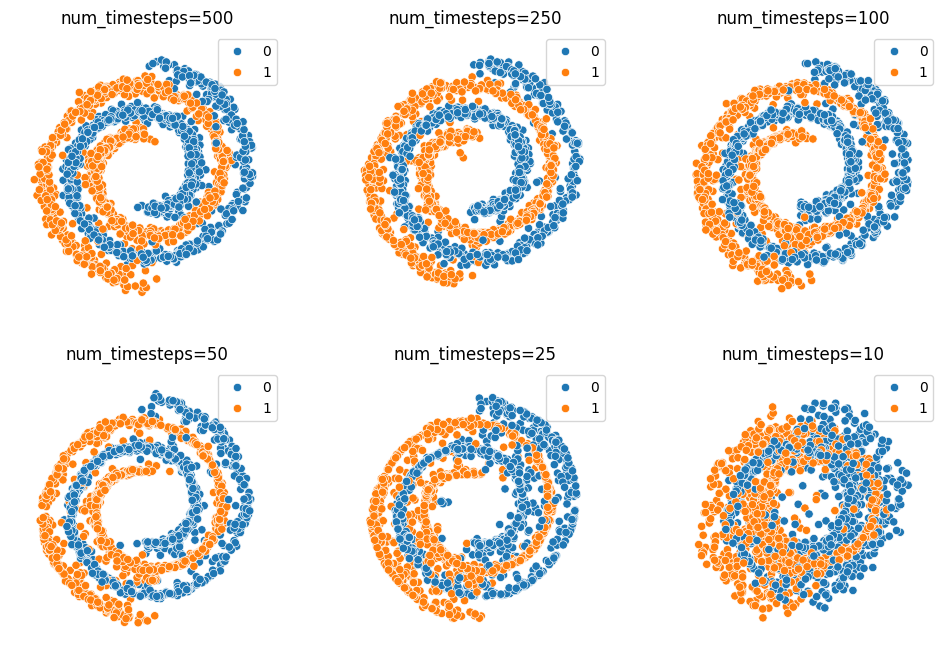

In [31]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 1).

guidance_scale = 1.

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

100%|██████████| 9/9 [00:00<00:00, 260.53it/s]


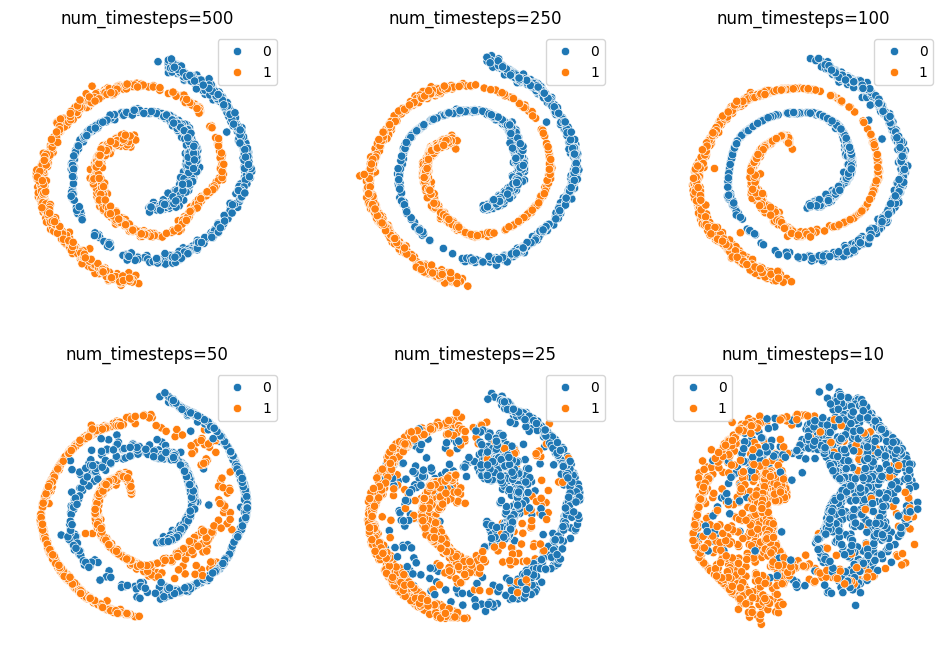

In [32]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 3).
guidance_scale = 3

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

Отлично! У нас получилось значительно сократить количество шагов генерации без особой потери в качестве!

## MNIST

В предыдущей части мы работали с двумерным датасетом SwissRoll.
Он может показаться слишком простым. Так и есть: именно из-за своей простоты он удобен для проверки и дебага нашего кода.

Теперь, когда мы видим, что наш код работает, протестируем его на чём-то посложнее — на MNIST!

In [33]:
# Скачаем датасет

from torchvision.datasets.mnist import MNIST

def mnist_to_train_range(X):
    return ((X.astype("float32") / 255.) - 0.5) * 2

def mnist_from_train_range(X):
    return (((X.astype("float32") + 1.0) / 2) * 255.).astype("int")

dataset = MNIST("./datasets", download=True, train=True)
X = dataset.data.numpy().astype("float32")[:, None]
y = dataset.targets.numpy()
mnist_loader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=64)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.54MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 247kB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.89MB/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



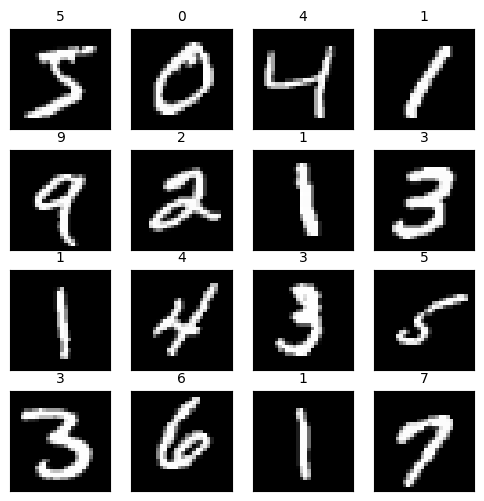

In [34]:
# Вспомогательная функция для визуализации

def show_images(images, ys, title=""):
    if type(images) is th.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)
    fig = plt.figure(figsize=(cols*1.5, rows*1.5))

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}", fontsize=10)
                plt.tick_params(bottom = False, left=False, labelbottom=False, labelleft=False)
                idx += 1
    plt.show()

def show_first_batch(loader, batch_size=16):
    for batch in loader:
        show_images(batch["x"][:batch_size], batch["y"][:batch_size], "Images in the first batch")
        break

show_first_batch(mnist_loader)

### Визуализируйте прямой процесс диффузии

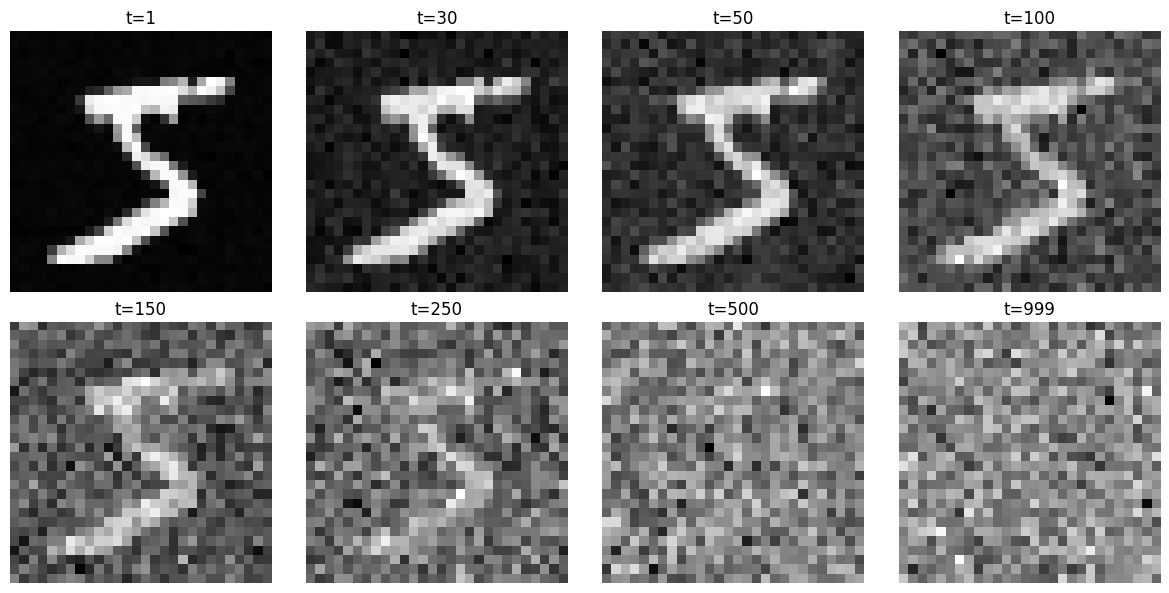

In [38]:
T = 1000
forward_diffusion = ForwardDiffusion(get_beta_schedule(T))

timesteps_to_plot = [1, 30, 50, 100, 150, 250, 500, 999]

image = next(iter(mnist_loader))["x"][:1, 0]

# ====
# ваш код
# по аналогии с тем, как мы делали для SwissRoll,
# примените прямой процесс диффузии к переменной image и
# визуализируйте зашумлённую картинку в разные моменты времени (включая самый последний шаг)

# Создаем визуализацию для разных моментов времени
n_plots = len(timesteps_to_plot)
ncols = 4
nrows = (n_plots + ncols - 1) // ncols  # Calculate rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3*nrows))
if nrows == 1:
    axes = [axes] if n_plots == 1 else axes  # Handle single row case
    axes = axes if hasattr(axes, '__len__') else [axes]  # Ensure it's iterable
else:
    axes = axes.flatten()

# Загружаем одно изображение из датасета MNIST
# Обязательно убираем лишние скобки [:1, 0], иначе получаем некорректную форму
image = next(iter(mnist_loader))["x"][:1]  # shape: (1, 1, 28, 28)

for i, t in enumerate(timesteps_to_plot):
    t_tensor = th.tensor([t], dtype=th.long)
    noised_image = forward_diffusion.q_sample(image, t_tensor)

    # Преобразуем тензор в numpy-массив и получаем корректную форму изображения
    img_np = noised_image[0, 0].cpu().numpy()  # shape: (28, 28)

    axes[i].imshow(img_np, cmap="gray")
    axes[i].set_title(f"t={t}")
    axes[i].axis("off")

# Скрываем неиспользуемые подграфики
for i in range(len(timesteps_to_plot), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()
# ====

### Обучите диффузионную модель и получите хорошие генерации с помощью неё

In [40]:
T = 1000
# ====
# ваш код
# выберите гиперпараметры
LR = 0.0001  # 0.0001 <= LR <= 0.01
N_ITERS = 80_000 # N_ITERS >= 5000
DROP_LABEL = 0.1 # 0.1 <= DROP_LABEL <= 0.5
BATCH_SIZE = 512 # 256 <= BATCH_SIZE <=  2048
# ====

model = MyUNet(use_null_cond=True)

ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=BATCH_SIZE, shuffle=True, drop_label=DROP_LABEL)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/80000 Loss: 0.4147
Step 1000/80000 Loss: 0.0958
Step 1500/80000 Loss: 0.0757
Step 2000/80000 Loss: 0.0677
Step 2500/80000 Loss: 0.062
Step 3000/80000 Loss: 0.0581
Step 3500/80000 Loss: 0.0551
Step 4000/80000 Loss: 0.0528
Step 4500/80000 Loss: 0.0506
Step 5000/80000 Loss: 0.0487
Step 5500/80000 Loss: 0.047
Step 6000/80000 Loss: 0.0455
Step 6500/80000 Loss: 0.0443
Step 7000/80000 Loss: 0.0434
Step 7500/80000 Loss: 0.0426
Step 8000/80000 Loss: 0.0416
Step 8500/80000 Loss: 0.041
Step 9000/80000 Loss: 0.0403
Step 9500/80000 Loss: 0.04
Step 10000/80000 Loss: 0.0393
Step 10500/80000 Loss: 0.0389
Step 11000/80000 Loss: 0.0383
Step 11500/80000 Loss: 0.038
Step 12000/80000 Loss: 0.0378
Step 12500/80000 Loss: 0.0374
Step 13000/80000 Loss: 0.0368
Step 13500/80000 Loss: 0.0368
Step 14000/80000 Loss: 0.0364
Step 14500/80000 Loss: 0.0361
Step 15000/80000 Loss: 0.0358
Step 15500/80000 Loss: 0.0354
Step 16000/80000 Loss: 0.0352
Step 16500/80000 Loss: 0.035
Step 17000/80000 Loss: 0.0349
Step 17

100%|██████████| 1000/1000 [00:02<00:00, 480.78it/s]


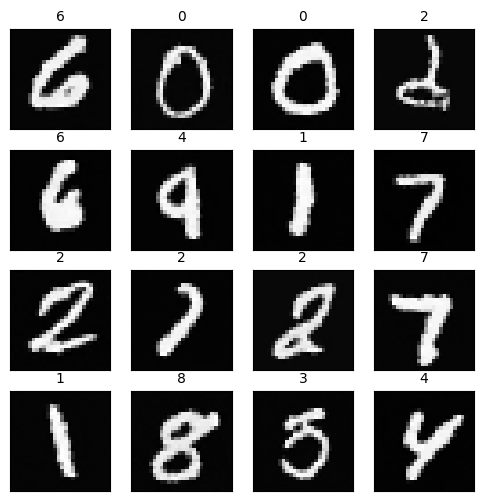

In [41]:
# Теперь давайте посмотрим, что наша модель научилась генерировать

num_samples = 16
ys = th.randint(10, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(ys)
show_images(Xs, ys)

### Сравните генерацию с помощью classifier-free с разными guidance scale

Сейчас для генерации в диффузионной модели нам нужно делать 1000 вызовов нейросети.

С classifier-free guidance потребуется 2000 вызовов.

Это долго, и с таким числом шагов сложно быстро экспериментировать.

Поэтому сначала подберём меньшее количество шагов семплирования без classifier-free guidance, при котором качество генерации остаётся хорошим, а затем будем использовать это количество шагов для сравнения разных значений guidance scale.

Используйте: `spaced_ddpm = get_spaced_ddpm(ddpm, ???)`


100%|██████████| 49/49 [00:00<00:00, 508.71it/s]


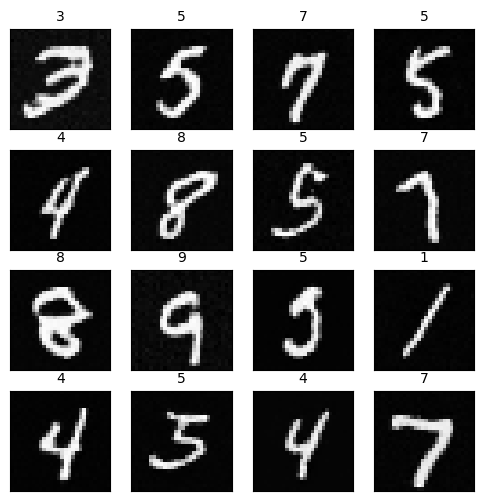

In [42]:
n_steps = 50
spaced_ddpm = get_spaced_ddpm(ddpm, n_steps)
# ====
# ваш код
# найдите меньшее число, чем T = 1000, шагов, с которым можно получать хорошие генерации.
# визуализируйте генерации с этим итоговым числом шагов
# Генерируем образцы с уменьшенным числом шагов
num_samples = 16
ys = th.randint(10, size=(num_samples,), device=device)
Xs, ys = spaced_ddpm.sample(ys)
show_images(Xs, ys)
# ====

Guidance scale: 1


100%|██████████| 49/49 [00:00<00:00, 278.88it/s]


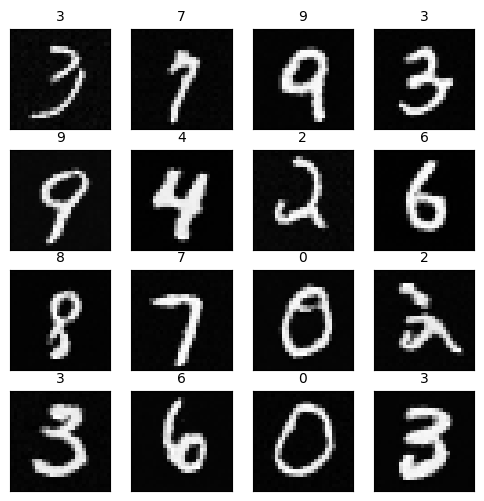

Guidance scale: 2


100%|██████████| 49/49 [00:00<00:00, 282.58it/s]


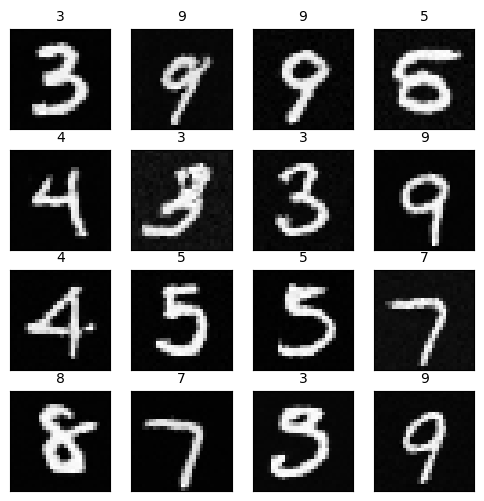

Guidance scale: 4


100%|██████████| 49/49 [00:00<00:00, 285.48it/s]


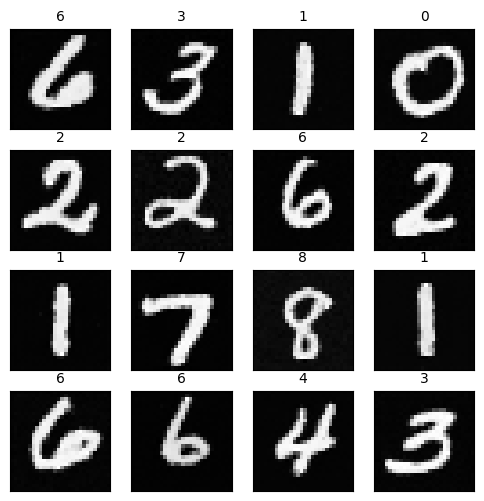

Guidance scale: 32


100%|██████████| 49/49 [00:00<00:00, 287.19it/s]


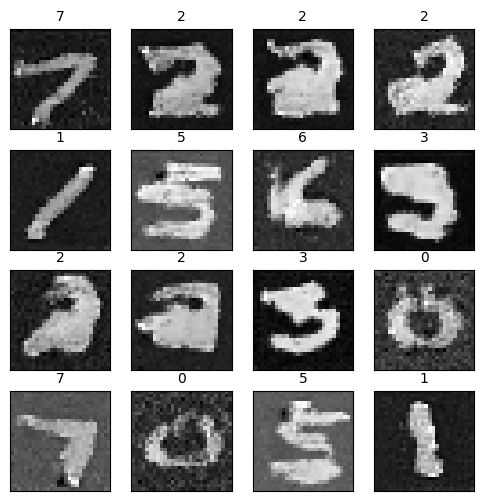

In [43]:
# ====
# ваш код
# визуализируйте генерации, полученные с помощью classifier-free guidance.
# сделайте это и сравните для guidance scale из множества {1, 2, 4, 32}
# (генерации можно визуализировать в разных ячейках)
guidance_scales = [1, 2, 4, 32]

for guidance_scale in guidance_scales:
    print(f"Guidance scale: {guidance_scale}")
    num_samples = 16
    ys = th.randint(10, size=(num_samples,), device=device)
    Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=10)
    show_images(Xs, ys)
# ====